In [ ]:
import os
os._exit(00)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
pip install blanc

In [ ]:
pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.5 MB/s eta 0:00:00


In [ ]:
pip install transformers

In [ ]:
pip install numpy

In [ ]:
pip install rouge

In [ ]:
input_folder = "/content/drive/MyDrive/Headnote Judgment"
output_folder_text = "/content/drive/MyDrive/Headnote Judgment/Judgment"
output_folder_headnotes = "/content/drive/MyDrive/Headnote Judgment/Summary"

## **Run to extract the file and its headnote and keeping it to different folders**

In [ ]:
import os
from PyPDF2 import PdfReader
import shutil
import re

# Define input and output folders
input_folder = "/content/drive/MyDrive/Headnote Judgment"
output_folder_text = "/content/drive/MyDrive/Headnote Judgment/Judgment"
output_folder_headnotes = "/content/drive/MyDrive/Headnote Judgment/Summary"

# Create output folders if they don't exist
os.makedirs(output_folder_text, exist_ok=True)
os.makedirs(output_folder_headnotes, exist_ok=True)

# Function to extract text and headnote from PDF file
def extract_text_and_headnote_from_pdf(pdf_path):
    pdf_reader = PdfReader(pdf_path)
    text = ""
    for page_num in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page_num].extract_text()

    text=text.lower()

    # Extract headnote using regular expression pattern
    headnote_search = re.search(r"headnote:(.*?)judgment:", text, re.DOTALL | re.IGNORECASE)
    if headnote_search:
        # Extract the headnote and remove leading/trailing spaces
        headnote = headnote_search.group(1).strip()
    else:
        headnote = "Headnote not found."

    return text, headnote

# Iterate through PDF files in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".pdf"):
        pdf_path = os.path.join(input_folder, filename)
        # Extract text and headnote from the PDF
        extracted_text, headnote = extract_text_and_headnote_from_pdf(pdf_path)

        # Write extracted text to the output text folder
        output_text_path = os.path.join(output_folder_text, f"{len(os.listdir(output_folder_text)) + 1}.txt")
        with open(output_text_path, "w", encoding="utf-8") as output_file:
            output_file.write(extracted_text)

        # Write headnote to the output headnotes folder
        output_headnote_path = os.path.join(output_folder_headnotes, f"{len(os.listdir(output_folder_headnotes)) + 1}.txt")
        with open(output_headnote_path, "w", encoding="utf-8") as headnote_output_file:
            headnote_output_file.write(headnote)

print("Extraction completed.")



Extraction completed.


## **InLegalbert**

In [ ]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from rouge import Rouge
import numpy as np


#from blanc import BlancHelp  #blanc evaluation
#blanc_help = BlancHelp() #added

# Load the InLegalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
model = AutoModel.from_pretrained("law-ai/InLegalBERT")

# Function to read text from a file
def read_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to generate summary using InLegalBERT
def generate_summary(text):
  tokenizer.max_len = model.config.max_position_embeddings

  # Encode the input text
  encoded_input = tokenizer(text, return_tensors="pt", truncation=True)
  output = model(**encoded_input)
  embeddings = output.pooler_output

# Making a summary using these embeddings
# Step 1: Compute sentence embeddings
  sentences = text.split('. ')  # Split text into sentences

# Calculate the desired number of sentences for the summary based on the percentage
  percentage = 0.3  # Adjust the desired percentage as needed
  num_sentences = int(len(sentences) * percentage)

  if len(sentences) < num_sentences:
      num_sentences = len(sentences)

  sentence_embeddings = []
  for sentence in sentences:
      encoded_input = tokenizer(sentence, return_tensors="pt", truncation=True)
      output = model(**encoded_input)
      sentence_embedding = output.pooler_output.squeeze(dim=0)
      sentence_embeddings.append(sentence_embedding.detach().numpy())

# Step 2: Compute similarity scores
  similarity_scores = []
  for i, embedding_i in enumerate(sentence_embeddings):
      similarity_scores_i = []
      for j, embedding_j in enumerate(sentence_embeddings):
          similarity = np.dot(embedding_i, embedding_j) / (
              np.linalg.norm(embedding_i) * np.linalg.norm(embedding_j)
          )
          similarity_scores_i.append(similarity)
      similarity_scores.append(similarity_scores_i)

  similarity_scores = np.array(similarity_scores)

# Step 3: Select top sentences
  summary_indices = np.argsort(-similarity_scores.sum(axis=1))[:num_sentences]
  summary_sentences = [sentences[i] for i in summary_indices]
  InLegal_summary = '. '.join(summary_sentences)
  return InLegal_summary

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/1 sample paheli/judgment'
summary_folder = '/content/drive/MyDrive/1 sample paheli/summary'

# Initialize lists to store evaluation metrics
file_names = []
rouge1_scores = []
rouge2_scores = []
rougel_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
#blanc_Score=[] #added

# List all files in the judgment folder
judgment_files = os.listdir(judgment_folder)

# Initialize Rouge object for evaluation
rouge = Rouge()

# Iterate through judgment files and generate summaries
for judgment_file in judgment_files:
    # Extract text from the judgment file
    judgment_file_path = os.path.join(judgment_folder, judgment_file)
    judgment_text = read_text_from_file(judgment_file_path)

    # Find corresponding summary file in the summary folder
    summary_file_path = os.path.join(summary_folder, judgment_file)

    # Read the reference summary from the summary file
    reference_summary = read_text_from_file(summary_file_path)

    # Generate summary using InLegalBERT
    generated_summary = generate_summary(judgment_text)

    # Calculate ROUGE scores
    rouge_scores = rouge.get_scores(generated_summary, reference_summary)[0]

    #blanc_score = blanc_help.eval_once(judgment_text, generated_summary) #added

    # Store the metrics in lists
    file_names.append(judgment_file)
    rouge1_scores.append(rouge_scores['rouge-1']['f'])
    rouge2_scores.append(rouge_scores['rouge-2']['f'])
    rougel_scores.append(rouge_scores['rouge-l']['f'])
    precision_scores.append(rouge_scores['rouge-l']['p'])
    recall_scores.append(rouge_scores['rouge-l']['r'])
    f1_scores.append(rouge_scores['rouge-l']['f'])
   # blanc_Score.append(blanc_score) #added


# Create a DataFrame from the lists
data = {
    'File Name': file_names,
    'InLegal ROUGE-1': rouge1_scores,
    'InLegal ROUGE-2': rouge2_scores,
    'InLegal ROUGE-L': rougel_scores,
    'InLegal Precision': precision_scores,
    'InLegal Recall': recall_scores,
    'InLegal F1 Score': f1_scores,
    #'Blanc Score':blanc_Score #added
}



In [ ]:
df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
excel_file_path = '/content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx'
df.to_excel(excel_file_path, index=False)

print(f"Evaluation metrics saved to {excel_file_path}")


Evaluation metrics saved to /content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx


In [ ]:
judgment_text

'N: Criminal Appeal No. 8 of 1951.\nAppeal from an Order of the High Court of Bombay (Bavdekar and Chainani JJ.) dated 20th February, 1950, in Criminal Appeal No. 106 of 1950 arising out of an order dated 9th January, 1950, of the Presidency Magistrate, 19th Court, Esplanade, Bombay, in Case No. 10879/P of 1949.\nThe facts are stated in the judgment.\nIswarlal C. Dalai and R.B. Dalai, for the appellant.\nC.K. Daphtary, Solicitor General for India (G. N. Joshi, with him) for the Republic of India (respondent No. 1).Jindra Lal for the respondent No. 2. 1952.\nFebruary 1.\nThe Judgment of the Court was deliv ered by CHANDRASEKHARA AIYAR J.\nThe facts out of which this Crimi nal Appeal has arisen are not long.\nThe appellant, W.H. King, who is carrying on a business in Bombay under the name and style of Associated Commercial Enterprises, was the tenant of a flat on the second floor of a building called "Ganga Vihar", Marine Drive, Bombay, which belongs to a lady named Durgeshwari Devi.\nTh

In [ ]:
generated_summary

'18 (a) of the Standing orders in this case, is subject to the scrutiny of industrial courts in the manner indicated above.\nThe appellant therefore cannot rest its case merely on r. has said in Srinivas Ganesh vs Union of India (2) (supra), wholly irrelevant.\nIt is urged that the same principle should be applied to industrial adjudication.\nIt is enough to say that the position of government servants stands on an entirely different footing as compared to industrial employees.\nArticles 310 and 311 of the Constitution apply to government servants and it is in the 829 light of those Articles read with the Rules framed under article 309 that questions relating to termination of service of government servants have to be considered.\nNo such constitutional provisions have to be considered when one is dealing with industrial employees.\nFurther an employer cannot now press his right purely on contract and say that under the contract he has unfettered right "to hire and fire" his employees.

## **LegalPegasus**

In [ ]:
pip install sentencepiece

In [ ]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge

# Load the Legal Pegasus model and tokenizer
legal_pegasus_tokenizer = AutoTokenizer.from_pretrained("nsi319/legal-pegasus")
legal_pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("nsi319/legal-pegasus")

# Function to read text from a file
def read_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to generate summary using Legal Pegasus
def generate_legal_pegasus_summary(text):
    input_tokenized = legal_pegasus_tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = legal_pegasus_model.generate(input_tokenized,
                                              num_beams=9,
                                              no_repeat_ngram_size=3,
                                              length_penalty=2.0,
                                              min_length=150,
                                              max_length=250,
                                              early_stopping=True)
    summary_legal_pegasus = [legal_pegasus_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0]
    return summary_legal_pegasus

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/1 sample paheli/judgment'
summary_folder = '/content/drive/MyDrive/1 sample paheli/summary'

# Load the existing DataFrame from the Excel file
excel_file_path = '/content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx'
df = pd.read_excel(excel_file_path)

# Initialize lists to store Legal Pegasus evaluation metrics
legal_pegasus_rouge1 = []
legal_pegasus_rouge2 = []
legal_pegasus_rougeL = []
legal_pegasus_precision = []
legal_pegasus_recall = []
legal_pegasus_f1_scores = []

# Initialize Rouge object for evaluation
rouge = Rouge()

# List all files in the judgment folder
judgment_files = os.listdir(judgment_folder)

# Iterate through judgment files and generate summaries using Legal Pegasus
for judgment_file in judgment_files:
    # Extract text from the judgment file
    judgment_file_path = os.path.join(judgment_folder, judgment_file)
    judgment_text = read_text_from_file(judgment_file_path)

    # Find corresponding summary file in the summary folder
    summary_file_path = os.path.join(summary_folder, judgment_file)

    # Read the reference summary from the summary file
    reference_summary = read_text_from_file(summary_file_path)

    # Generate summary using Legal Pegasus
    generated_summary_legal_pegasus = generate_legal_pegasus_summary(judgment_text)

    # Calculate ROUGE scores for Legal Pegasus
    rouge_scores_legal_pegasus = rouge.get_scores(generated_summary_legal_pegasus, reference_summary)[0]

    # Append metrics to the respective lists
    legal_pegasus_rouge1.append(rouge_scores_legal_pegasus['rouge-1']['f'])
    legal_pegasus_rouge2.append(rouge_scores_legal_pegasus['rouge-2']['f'])
    legal_pegasus_rougeL.append(rouge_scores_legal_pegasus['rouge-l']['f'])
    legal_pegasus_precision.append(rouge_scores_legal_pegasus['rouge-l']['p'])
    legal_pegasus_recall.append(rouge_scores_legal_pegasus['rouge-l']['r'])
    legal_pegasus_f1_scores.append(rouge_scores_legal_pegasus['rouge-l']['f'])

# Add Legal Pegasus evaluation metrics to the DataFrame
df['LegalPegasus_ROUGE1'] = legal_pegasus_rouge1
df['LegalPegasus_ROUGE2'] = legal_pegasus_rouge2
df['LegalPegasus_ROUGEL'] = legal_pegasus_rougeL
df['LegalPegasus_Precision'] = legal_pegasus_precision
df['LegalPegasus_Recall'] = legal_pegasus_recall
df['LegalPegasus'] = legal_pegasus_f1_scores


# Save the updated DataFrame to the same Excel file
df.to_excel(excel_file_path, index=False)

print(f"Legal Pegasus evaluation metrics added to {excel_file_path}")


Legal Pegasus evaluation metrics added to /content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx


In [ ]:
generated_summary_legal_pegasus

'On March 18, 1952, the Chief Presidency Magistrate, Bombay, acquitted all the accused including the appellants and held that as the conciliation proceedings had continued for a period of more than 14 days as from January 17, 1952, further proceedings for conciliation were illegal. The State took an appeal to the High Court and the judgment of acquittal was reversed and of the accused persons the two appellants were convicted and the others were acquitted. The appeal has been filed by H.J. Umrigar and B.H. Dhebar on behalf of the Andheri Marol Kurla Bus Service who was accused No. 1 (now appellant No. 1) and its Manager H.M. Khan. The question for decision is whether conciliation proceedings could be said to be pending when Louis Pereira was dismissed. The appellants have appealed by special leave. If the answer is in the affirmative then they have been properly convicted and if not the conviction must be set aside. Section 31(1) makes the contravention of the provision of section 33 o

## **Lex,Luhn,Text**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 950.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 23.4 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21691 sha256=a727dfddb17e9a845cc2f1585398861958785e6d871a2e02f5a8a1525e0fc559
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=24cfb9fe2c3352456309395770b7d43c1c62d5f97a47872fe9c579a4e08add8c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
import pandas as pd
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.utils import get_stop_words
from rouge import Rouge

# Function to read text from a file
def read_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to perform summarization using LexRank
def lex_rank_summarize(text, num_sentences):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summarizer.stop_words = get_stop_words("english")
    summary = summarizer(parser.document, sentences_count=num_sentences)
    return " ".join([str(sentence) for sentence in summary])

# Function to perform summarization using Luhn
def luhn_summarize(text, num_sentences):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LuhnSummarizer()
    summarizer.stop_words = get_stop_words("english")
    summary = summarizer(parser.document, sentences_count=num_sentences)
    return " ".join([str(sentence) for sentence in summary])

# Function to perform summarization using TextRank
def text_rank_summarize(text, num_sentences):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summarizer.stop_words = get_stop_words("english")
    summary = summarizer(parser.document, sentences_count=num_sentences)
    return " ".join([str(sentence) for sentence in summary])

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/dataset/IN-Abs/test-data/judgement'
summary_folder = '/content/drive/MyDrive/dataset/IN-Abs/test-data/summary'

# Load the existing DataFrame from the Excel file
excel_file_path = '/content/drive/MyDrive/dataset/IN-Abs/test-data/kharagpur data test.xlsx'
df = pd.read_excel(excel_file_path)

# Initialize lists to store LexRank, Luhn, and TextRank evaluation metrics
lex_rank_rouge1 = []
lex_rank_rouge2 = []
lex_rank_rougeL = []
lex_rank_precision = []
lex_rank_recall = []
lex_rank_f1_scores = []
luhn_rouge1 = []
luhn_rouge2 = []
luhn_rougeL = []
luhn_precision = []
luhn_recall = []
luhn_f1_scores = []
text_rank_rouge1 = []
text_rank_rouge2 = []
text_rank_rougeL = []
text_rank_precision = []
text_rank_recall = []
text_rank_f1_scores = []

# Initialize Rouge object for evaluation
rouge = Rouge()

# List all files in the judgment folder
judgment_files = os.listdir(judgment_folder)

# Iterate through judgment files and generate summaries using LexRank, Luhn, and TextRank
for judgment_file in judgment_files:
    # Extract text from the judgment file
    judgment_file_path = os.path.join(judgment_folder, judgment_file)
    judgment_text = read_text_from_file(judgment_file_path)

    num_sentences = int(0.5 * len(judgment_text.split('. ')))

    # Find corresponding summary file in the summary folder
    summary_file_path = os.path.join(summary_folder, judgment_file)
    # Read the reference summary from the summary file
    reference_summary = read_text_from_file(summary_file_path)

    # LexRank Summarization
    lex_summary = lex_rank_summarize(judgment_text, num_sentences)
    lex_summary= lex_summary.replace(u'\xa0',' ')
    lex_summary= lex_summary.replace(u'\xad',' ')
    lex_summary= lex_summary.replace(u'\n',' ')
    lex_summary= lex_summary.replace(u'...',' ')
    lex_scores = rouge.get_scores(lex_summary, reference_summary)[0]
    lex_rank_rouge1.append(lex_scores['rouge-1']['f'])
    lex_rank_rouge2.append(lex_scores['rouge-2']['f'])
    lex_rank_rougeL.append(lex_scores['rouge-l']['f'])
    lex_rank_precision.append(lex_scores['rouge-l']['p'])
    lex_rank_recall.append(lex_scores['rouge-l']['r'])
    lex_rank_f1_scores.append((lex_scores['rouge-l']['f']))

    # Luhn Summarization
    luhn_summary = luhn_summarize(judgment_text, num_sentences)
    luhn_summary = luhn_summary.replace(u'\xa0',' ')
    luhn_summary = luhn_summary.replace(u'\xad',' ')
    luhn_summary = luhn_summary.replace(u'\n',' ')
    luhn_summary = luhn_summary.replace(u'...',' ')
    luhn_scores = rouge.get_scores(luhn_summary, reference_summary)[0]
    luhn_rouge1.append(luhn_scores['rouge-1']['f'])
    luhn_rouge2.append(luhn_scores['rouge-2']['f'])
    luhn_rougeL.append(luhn_scores['rouge-l']['f'])
    luhn_precision.append(luhn_scores['rouge-l']['p'])
    luhn_recall.append(luhn_scores['rouge-l']['r'])
    luhn_f1_scores.append((luhn_scores['rouge-l']['f']))

    # TextRank Summarization
    text_rank_summary = text_rank_summarize(judgment_text, num_sentences)
    text_rank_summary = text_rank_summary.replace(u'\xa0',' ')
    text_rank_summary = text_rank_summary.replace(u'\xad',' ')
    text_rank_summary = text_rank_summary.replace(u'\n',' ')
    text_rank_summary = text_rank_summary.replace(u'...',' ')
    text_rank_scores = rouge.get_scores(text_rank_summary, reference_summary)[0]
    text_rank_rouge1.append(text_rank_scores['rouge-1']['f'])
    text_rank_rouge2.append(text_rank_scores['rouge-2']['f'])
    text_rank_rougeL.append(text_rank_scores['rouge-l']['f'])
    text_rank_precision.append(text_rank_scores['rouge-l']['p'])
    text_rank_recall.append(text_rank_scores['rouge-l']['r'])
    text_rank_f1_scores.append((text_rank_scores['rouge-l']['f']))

# Add LexRank, Luhn, and TextRank evaluation metrics to the DataFrame
df['LexRank_ROUGE1'] = lex_rank_rouge1
df['LexRank_ROUGE2'] = lex_rank_rouge2
df['LexRank_ROUGEL'] = lex_rank_rougeL
df['LexRank_Precision'] = lex_rank_precision
df['LexRank_Recall'] = lex_rank_recall
df['LexRank_F1'] = lex_rank_f1_scores
df['Luhn_ROUGE1'] = luhn_rouge1
df['Luhn_ROUGE2'] = luhn_rouge2
df['Luhn_ROUGEL'] = luhn_rougeL
df['Luhn_Precision'] = luhn_precision
df['Luhn_Recall'] = luhn_recall
df['Luhn_F1'] = luhn_f1_scores
df['TextRank_ROUGE1'] = text_rank_rouge1
df['TextRank_ROUGE2'] = text_rank_rouge2
df['TextRank_ROUGEL'] = text_rank_rougeL
df['TextRank_Precision'] = text_rank_precision
df['TextRank_Recall'] = text_rank_recall
df['TextRank_F1'] = text_rank_f1_scores

# Save the updated DataFrame to the same Excel file
df.to_excel(excel_file_path, index=False)

print(f"LexRank, Luhn, and TextRank evaluation metrics added to {excel_file_path}")


LexRank, Luhn, and TextRank evaluation metrics added to /content/drive/MyDrive/dataset/IN-Abs/test-data/kharagpur data test.xlsx


In [ ]:
text_rank_summary

'It then moved the High Court under section 66 (2) of the Act and the High Court directed the Tribunal to refer the following question for determination by it: "Whether, on the facts and in the circumstances of the case, the assessee is not entitled to relief under section 25 (4) of the Indian Income tax Act, and to what extent?" (3) of that section will throw useful light on the matter 96 in question and so we set both these sub sections out below: section 25 (3) Where any business, profession or vocation on which tax was at any time charged under the provisions of the Indian Income tax Act, 1918, . (4) Where the person who was at the commencement of the Indian Income tax (Amendment) Act, 1939 carrying on any business, profession or vocation on which tax was at any time charged under the provisions of the Indian Income tax Act, 1918, is succeeded in such capacity by another person, the change not being merely a change in the constitution of a partnership, no tax shall be payable by th

## T5 **Model**

In [ ]:
pip install sentencepiece

In [ ]:
import os
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rouge import Rouge

# Load the model and tokenizer
#tokenizer = T5Tokenizer.from_pretrained('/content/drive/MyDrive/fine_tuned_t5')
#model = T5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/fine_tuned_t5')

fine_tuned_model_path = '/content/drive/MyDrive/fine_tuned_t5'  # Replace with the actual path to your fine-tuned model
tokenizer = T5Tokenizer.from_pretrained('/content/drive/MyDrive/fine_tuned_t5')
model = T5ForConditionalGeneration.from_pretrained(fine_tuned_model_path, return_dict=True)


rouge = Rouge()

def read_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def generate_summary_T5(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)
    #total_tokens = len(input_ids[0])
    #target_length = total_tokens // 2
    summary_ids = model.generate(input_ids, max_length=512, min_length=32, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/judgement'
summary_folder = '/content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/summary'
excel_file_path = '/content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx'

# Load the existing DataFrame from the Excel file
# If the Excel file is empty or doesn't exist, create an empty DataFrame with the correct columns
try:
    df = pd.read_excel(excel_file_path)
    # If the DataFrame has only one row, re-initialize it with the correct columns
    if df.shape[0] == 1:
        df = pd.DataFrame(columns=['File Name'])  # Assuming 'File Name' is the first column
except FileNotFoundError:
    df = pd.DataFrame(columns=['File Name'])  # Assuming 'File Name' is the first column

# Initialize lists to store evaluation metrics
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
file_names = []  # Add a list to store file names


# List all files in the judgment folder
judgment_files = os.listdir(judgment_folder)
i=1
# Iterate through judgment files and generate summaries, calculate ROUGE scores
for judgment_file in judgment_files:
    # Extract text from the judgment file
    judgment_file_path = os.path.join(judgment_folder, judgment_file)
    judgment_text = read_text_from_file(judgment_file_path)

    # Find corresponding summary file in the summary folder
    summary_file_path = os.path.join(summary_folder, judgment_file)

    # Read the reference summary from the summary file
    reference_summary = read_text_from_file(summary_file_path)

    # Generate summary
    generated_summary = generate_summary_T5(judgment_text)

    # Calculate ROUGE scores
    rouge_scores = rouge.get_scores(generated_summary, reference_summary)[0]

    # Append metrics and file name to the respective lists
    rouge1_scores.append(rouge_scores['rouge-1']['f'])
    rouge2_scores.append(rouge_scores['rouge-2']['f'])
    rougeL_scores.append(rouge_scores['rouge-l']['f'])
    precision_scores.append(rouge_scores['rouge-l']['p'])
    recall_scores.append(rouge_scores['rouge-l']['r'])
    f1_scores.append(rouge_scores['rouge-l']['f'])
    file_names.append(judgment_file) # Add file name to the list
    print("Done", i)
    i=i+1

# Create a new DataFrame with the evaluation metrics and file names
data = {
    'File Name': file_names,  # Include file names
    'T5 ROUGE-1': rouge1_scores,
    'T5 ROUGE-2': rouge2_scores,
    'T5 ROUGE-L': rougeL_scores,
    'T5 Precision': precision_scores,
    'T5 Recall': recall_scores,
    'T5 F1 Score': f1_scores,
}
df_t5 = pd.DataFrame(data)

# Save the new DataFrame to an Excel file
df_t5.to_excel(excel_file_path, index=False)

print(f"Evaluation metrics added to {excel_file_path}")

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49
Done 50
Done 51
Done 52
Done 53
Done 54
Done 55
Done 56
Done 57
Done 58
Done 59
Done 60
Done 61
Done 62
Done 63
Done 64
Done 65
Done 66
Done 67
Done 68
Done 69
Done 70
Done 71
Done 72
Done 73
Done 74
Done 75
Done 76
Done 77
Done 78
Done 79
Done 80
Done 81
Done 82
Done 83
Done 84
Done 85
Done 86
Done 87
Done 88
Done 89
Done 90
Done 91
Done 92
Done 93
Done 94
Done 95
Done 96
Done 97
Done 98
Done 99
Done 100
Evaluation metrics added to /content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx


In [ ]:
generated_summary

'iminal Appeal No. 46 of 1957. This is an appeal by special leave from the judgment and order dated the February 4, 1955, of the Bombay High Court in Criminal Appeal No. 1256 of 1954. The appellants are the Andheri Marol Kurla Bus Service who was accused No. 1 (now appellant No. 1) and its Manager H. M. Khan (now appellant No. 2).'

## **BART**

In [ ]:
import os
import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration
from rouge import Rouge

# Initialize BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/1 sample paheli/judgment'
summary_folder = '/content/drive/MyDrive/1 sample paheli/summary'
excel_file_path = '/content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx'

# Load the existing DataFrame from the Excel file
df = pd.read_excel(excel_file_path)

# Initialize lists to store BART evaluation metrics
bart_rouge1 = []
bart_rouge2 = []
bart_rougel = []
bart_precision = []
bart_recall = []

# Initialize Rouge object for evaluation
rouge = Rouge()

# Iterate through judgment files and generate BART summaries
for judgment_file in os.listdir(judgment_folder):
    # Read judgment text from file
    with open(os.path.join(judgment_folder, judgment_file), 'r', encoding='utf-8') as file:
        judgment_text = file.read()

    # Generate BART summary
    inputs = tokenizer([judgment_text], truncation=True, return_tensors='pt')
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, early_stopping=False, min_length=0, max_length=1024)
    bart_summary = ([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summary_ids])

    # Read corresponding reference summary from file
    with open(os.path.join(summary_folder, judgment_file), 'r', encoding='utf-8') as file:
        reference_summary = file.read()

    # Calculate ROUGE scores for BART summary
    rouge_scores_bart = rouge.get_scores(bart_summary[0], reference_summary)[0]

    # Append metrics to the respective lists
    bart_rouge1.append(rouge_scores_bart['rouge-1']['f'])
    bart_rouge2.append(rouge_scores_bart['rouge-2']['f'])
    bart_rougel.append(rouge_scores_bart['rouge-l']['f'])
    bart_precision.append(rouge_scores_bart['rouge-l']['p'])
    bart_recall.append(rouge_scores_bart['rouge-l']['r'])

# Add evaluation metrics to the DataFrame
df['BART_ROUGE1'] =  bart_rouge1
df['BART_ROUGE2'] = bart_rouge2
df['BART_ROUGEL'] = bart_rougel
df['BART_Precision'] = bart_precision
df['BART_Recall'] = bart_recall

# Save the BART evaluation metrics to the Excel file
df.to_excel(excel_file_path, index=False)

print(f"BART evaluation metrics added to {excel_file_path}")


BART evaluation metrics added to /content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx


In [ ]:
bart_summary

[' An appeal by special leave against the judgment and order of the High Court of Bombay reversing the judgment of the Chief Presidency Magistrate, Bombay, in Case No. 176/S of 1953. The two appellants are the Andheri Marol Kurla Bus Service who was accused No. 1 and its Manager H. M. Khan. The State took an appeal to the. High Court and the. judgment of acquittal was reversed and of the accused persons the two. appellants were convicted and the others were acquitted. The question for decision is whether the conciliation proceedings could be said to be. said to have been pending when Louis Pereira was dismissed.']

## **LetSum not working** **bold text**

In [ ]:
import os
import pandas as pd
import nltk
import numpy as np
import re
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge

# Load NLTK stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

# Function to normalize documents
def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

# Function to perform LSA
def perform_lsa(sentences, num_topics=3, sv_threshold=0.5, percentage=0.5):
    norm_sentences = [normalize_document(sentence) for sentence in sentences]
    tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
    dt_matrix = tv.fit_transform(norm_sentences)
    dt_matrix = dt_matrix.toarray()
    vocab = tv.get_feature_names_out()
    td_matrix = dt_matrix.T
    print(td_matrix.shape)
    pd.DataFrame(np.round(td_matrix, 2), index=vocab).head(10)

    u, s, vt = low_rank_svd(dt_matrix, singular_count=num_topics)
    term_topic_mat, singular_values, topic_document_mat = u, s, vt

    # Remove singular values below threshold
    min_sigma_value = max(singular_values) * sv_threshold
    singular_values[singular_values < min_sigma_value] = 0

    salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))
    top_sentence_indices = (-salience_scores).argsort()[:int(len(sentences) * percentage)]
    top_sentence_indices.sort()

    summary_sentences =('\n'.join(np.array(sentences)[top_sentence_indices]))
    return (summary_sentences)

# Function to perform low-rank SVD
def low_rank_svd(matrix, singular_count=2):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/to be delete/judgment'
summary_folder = '/content/drive/MyDrive/to be delete/summary'
excel_file_path = '/content/drive/MyDrive/to be delete/getreadings.xlsx'
df = pd.read_excel(excel_file_path)

# Initialize lists to store LSA evaluation metrics
lsa_rouge1 = []
lsa_rouge2 = []
lsa_rougel = []
lsa_precision = []
lsa_recall = []

# Initialize Rouge object for evaluation
rouge = Rouge()

# Iterate through judgment files and generate LSA summaries
for judgment_file in os.listdir(judgment_folder):
    # Read judgment text from file
    with open(os.path.join(judgment_folder, judgment_file), 'r', encoding='utf-8') as file:
        judgment_text = file.read()

    # Read corresponding reference summary from file
    with open(os.path.join(summary_folder, judgment_file), 'r', encoding='utf-8') as file:
        reference_summary = file.read()

    # Generate LSA summary
    lsa_summary = perform_lsa(nltk.sent_tokenize(judgment_text))

    # Calculate ROUGE scores for LSA summary
    rouge_scores_lsa = rouge.get_scores(lsa_summary, reference_summary)[0]

    # Check if the list has enough elements before accessing specific indices
    if len(sentences) >= 74:  # Check against the problematic index (73)
        # Append metrics to the respective lists
        lsa_rouge1.append(rouge_scores_lsa['rouge-1']['f'])
        lsa_rouge2.append(rouge_scores_lsa['rouge-2']['f'])
        lsa_rougel.append(rouge_scores_lsa['rouge-l']['f'])
        lsa_precision.append(rouge_scores_lsa['rouge-l']['p'])
        lsa_recall.append(rouge_scores_lsa['rouge-l']['r'])
    else:
        print(f"Skipping judgment file: {judgment_file} due to insufficient sentences.")

# Create a DataFrame to store evaluation results
df_lsa = pd.DataFrame({
    '': lsa_rouge1,
    'LSA_ROUGE2': lsa_rouge2,
    'LSA_ROUGEL': lsa_rougel,
    'LSA_Precision': lsa_precision,
    'LSA_Recall': lsa_recall
})

df['BART_ROUGE1'] = rouge1_scores
df['BART_ROUGE2'] = rouge2_scores
df['BART_ROUGEL'] = rougeL_scores
df['BART_Precision'] = precision_scores
df['BART_Recall'] = recall_scores
# Save the LSA evaluation metrics to the Excel file
df_lsa.to_excel(excel_file_path, index=False)

print(f"LSA evaluation metrics added to {excel_file_path}")


(343, 60)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


IndexError: ignored

In [ ]:
lsa_summary

## **LSA Reviewed (This is LSA not Letsum)**

In [ ]:
pip install scikit-learn

In [ ]:
import nltk
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds

nltk.download('punkt')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
    doc = doc.lower().strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

def low_rank_svd(matrix, singular_count=2):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

def generate_letsum_summary(text, num_topics=3, percentage_of_sentences=0.5):
    sentences = nltk.sent_tokenize(text)
    norm_sentences = [normalize_document(sentence) for sentence in sentences]

    tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
    dt_matrix = tv.fit_transform(norm_sentences)
    dt_matrix = dt_matrix.toarray()

    vocab = tv.get_feature_names_out()
    td_matrix = dt_matrix.T

    u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)

    sv_threshold = 0.5
    min_sigma_value = max(s) * sv_threshold
    s[s < min_sigma_value] = 0

    salience_scores = np.sqrt(np.dot(np.square(s), np.square(vt)))

    num_sentences = int(len(sentences) * percentage_of_sentences)
    if len(sentences) < num_sentences:
        num_sentences = len(sentences)

    top_sentence_indices = (-salience_scores).argsort()[:num_sentences]
    top_sentence_indices.sort()

    letsum_summary = ' '.join(np.array(sentences)[top_sentence_indices])
    return letsum_summary


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import os
import pandas as pd
from rouge import Rouge

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/dataset/IN-Abs/test-data/judgement'
summary_folder = '/content/drive/MyDrive/dataset/IN-Abs/test-data/summary'
excel_file_path = '/content/drive/MyDrive/dataset/IN-Abs/test-data/kharagpur data test.xlsx'

# Load existing DataFrame from the Excel file
df = pd.read_excel(excel_file_path)

# Initialize lists to store LetSum evaluation metrics
letsum_rouge1 = []
letsum_rouge2 = []
letsum_rougel = []
letsum_precision = []
letsum_recall = []
letsum_f1_scores = []

# Initialize Rouge object for evaluation
rouge = Rouge()

# Iterate through judgment files and generate LetSum summaries
for judgment_file in os.listdir(judgment_folder):
    # Read judgment text from file
    with open(os.path.join(judgment_folder, judgment_file), 'r', encoding='utf-8') as file:
        judgment_text = file.read()

    # Read corresponding summary text from file
    with open(os.path.join(summary_folder, judgment_file), 'r', encoding='utf-8') as file:
        reference_summary = file.read()

    # Generate LetSum summary
    letsum_summary = generate_letsum_summary(judgment_text)
    letsum_summary= letsum_summary.replace(u'\xa0',' ')
    letsum_summary= letsum_summary.replace(u'\xad',' ')
    letsum_summary= letsum_summary.replace(u'\n',' ')


    # Calculate ROUGE scores for LetSum summary
    rouge_scores_letsum = rouge.get_scores(letsum_summary, reference_summary)[0]

    # Append metrics to the respective lists
    letsum_rouge1.append(rouge_scores_letsum['rouge-1']['f'])
    letsum_rouge2.append(rouge_scores_letsum['rouge-2']['f'])
    letsum_rougel.append(rouge_scores_letsum['rouge-l']['f'])
    letsum_precision.append(rouge_scores_letsum['rouge-l']['p'])
    letsum_recall.append(rouge_scores_letsum['rouge-l']['r'])
    letsum_f1_scores.append(rouge_scores_letsum['rouge-l']['f'])

# Add LetSum evaluation metrics to the DataFrame
df['LetSum_ROUGE1'] = letsum_rouge1
df['LetSum_ROUGE2'] = letsum_rouge2
df['LetSum_ROUGEL'] = letsum_rougel
df['LetSum_Precision'] = letsum_precision
df['LetSum_Recall'] = letsum_recall
df['LetSum_F1'] = letsum_f1_scores

# Save the updated DataFrame to the Excel file
df.to_excel(excel_file_path, index=False)

print(f"LetSum evaluation metrics added to {excel_file_path}")


LetSum evaluation metrics added to /content/drive/MyDrive/dataset/IN-Abs/test-data/kharagpur data test.xlsx


In [ ]:
letsum_summary

'supreme court of india collector land acquisition,   vs mst. katiji & ors on 19 february, 1987 equivalent citations: 1987 air 1353, 1987 scr (2) 387 author: m thakkar bench: thakkar, m.p. (j)            petitioner: collector land acquisition, anantnag & anr. vs. respondent: mst. katiji & ors. date of judgment19/02/1987 bench: thakkar, m.p. (j) bench: thakkar, m.p. civil appellate jurisdiction: civil appeal no. 1986 of the jammu & and kashmir high court in civil 1st appeal no. the order of the court was delivered by thakkar, j. to condone, or not to condone, is not the only question. an appeal preferred by the state of jammu & kashmir arising out of a decision enhancing compensation in respect of acquisition of lands for a public purpose to the extent of nearly 14 lakhs rupees by making an upward revision of the order of 800% (from rs. the legislature has conferred the power to condone delay by enacting section 51 of the indian limitation act of 1963 in order to enable the courts to do

## **BERT (New dataframe is being created in this, so better to save this record in another excel sheet)**

In [ ]:
pip install bert-extractive-summarizer

In [ ]:
import os
import pandas as pd
from summarizer import Summarizer
from rouge import Rouge

# Initialize BERT-based extractive summarizer
model = Summarizer()

# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/1 sample paheli/judgment'
summary_folder = '/content/drive/MyDrive/1 sample paheli/summary'
excel_file_path = '/content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx'
# Initialize lists to store BERT evaluation metrics
bert_rouge1 = []
bert_rouge2 = []
bert_rougel = []
bert_precision = []
bert_recall = []

# Initialize Rouge object for evaluation
rouge = Rouge()

# Iterate through judgment files and generate BERT summaries
for judgment_file in os.listdir(judgment_folder):
    # Read judgment text from file
    with open(os.path.join(judgment_folder, judgment_file), 'r', encoding='utf-8') as file:
        judgment_text = file.read()

    # Generate BERT summary
    bert_summary = model(judgment_text)

    # Read corresponding reference summary from file
    with open(os.path.join(summary_folder, judgment_file), 'r', encoding='utf-8') as file:
        reference_summary = file.read()

    # Calculate ROUGE scores for BERT summary
    rouge_scores_bert = rouge.get_scores(bert_summary, reference_summary)[0]

    # Append metrics to the respective lists
    bert_rouge1.append(rouge_scores_bert['rouge-1']['f'])
    bert_rouge2.append(rouge_scores_bert['rouge-2']['f'])
    bert_rougel.append(rouge_scores_bert['rouge-l']['f'])
    bert_precision.append(rouge_scores_bert['rouge-l']['p'])
    bert_recall.append(rouge_scores_bert['rouge-l']['r'])

# Create a DataFrame to store evaluation results
df_bert = pd.DataFrame({
    'BERT_ROUGE1': bert_rouge1,
    'BERT_ROUGE2': bert_rouge2,
    'BERT_ROUGEL': bert_rougel,
    'BERT_Precision': bert_precision,
    'BERT_Recall': bert_recall
})

# Save the BERT evaluation metrics to the Excel file
df_bert.to_excel(excel_file_path, index=False)

print(f"BERT evaluation metrics added to {excel_file_path}")


BERT evaluation metrics added to /content/drive/MyDrive/Paheli dataset/IN-Abs/test-data/kharagpur_data_test.xlsx


In [ ]:
bert_summary

'Appeal by special leave from the judgment and order dated the February 4, 1955, of the Bombay High Court in Criminal Appeal No. H. J. Umrigar and B. H. Dhebar, for the respondent. I was asked to appear before the Conciliation Officer on January 9, 1952, and after getting one adjournment the appellant No. On May 9, 1952, the Union had also indicated to the Conciliation Officer that the negotiations had failed. The argument raised on behalf of the appellant is that the object of conciliation is to get a settlement made with expedition and therefore under section 12 the Conciliation Officer was bound to make his report within 14 days of the commencement of the conciliation proceedings or within such shorter period fixed by the appropriate Government. That sub section is as follows: section 20(1). . . . . . . . . ( He is required to bring about settlement between the parties and must begin his investigation without delay and if no settlement is arrived at he is to submit his report to the

# **InLegalBERT with KMeans method**

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [ ]:
import os
import numpy as np
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModel
from rouge import Rouge
from sklearn.cluster import KMeans

# Load the InLegalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
model = AutoModel.from_pretrained("law-ai/InLegalBERT")
import re

# Function to read text from a file
def read_text_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()


def filter_sentences(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        # Remove very short sentences
        if len(sentence.split()) < 5:
            continue
        # Exclude sentences that are mostly numbers or symbols
        if re.match(r'^[\d\W]+$', sentence.strip()):
            continue
        # Exclude sentences with just procedural references
        if re.search(r'rule|section|clause|subsection|schedule|no\.', sentence.lower()) and len(sentence.split()) < 10:
            continue
        # Exclude overly generic or non-informative phrases
        if sentence.strip() in ["No.", "etc.)"]:
            continue
        cleaned_sentences.append(sentence.strip())
    return cleaned_sentences

def score_sentences(sentences):
    # Assign weights based on keywords
    keyword_weights = {
        "court": 3,
        "appeal": 3,
        "appellant": 5,
        "respondent": 5,
        "delivered by": 5,
        "judgment": 4,
        "result": 4,
    }
    scored_sentences = []
    for sentence in sentences:
        score = sum(keyword_weights.get(word.lower(), 0) for word in sentence.split())
        scored_sentences.append((sentence, score))
    # Sort sentences by score in descending order
    scored_sentences.sort(key=lambda x: -x[1])
    return [sentence for sentence, _ in scored_sentences]



def reorder_summary_with_structure(sentences):
    case_details = []
    court_reasoning = []
    judgment_result = []

    for sentence in sentences:
        # Classify sentences into groups
        if any(keyword in sentence.lower() for keyword in ["appeal", "case", "facts", "background", "context"]):
            case_details.append(sentence)
        elif any(keyword in sentence.lower() for keyword in ["tribunal", "court", "reasoning", "held", "ruled"]):
            court_reasoning.append(sentence)
        elif any(keyword in sentence.lower() for keyword in ["dismissed", "allowed", "decision", "result", "judgment"]):
            judgment_result.append(sentence)
        else:
            court_reasoning.append(sentence)  # Default to reasoning if unclassified

    # Assemble sentences in the desired order
    ordered_summary = case_details + court_reasoning + judgment_result
    return ordered_summary
# Function to get sentence embeddings
def get_sentence_embedding(sentence, tokenizer, model):
    encoded_input = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    output = model(**encoded_input)
    embeddings = output.last_hidden_state.mean(dim=1)
    return embeddings.detach().numpy()

# Function to rank sentences using clustering while keeping track of original positions
def cluster_and_rank_sentences(sentences, embeddings, num_sentences):
    # Perform k-means clustering
    num_clusters = min(len(sentences), num_sentences)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    print("Number of clusters: ", num_clusters)

    # Select the closest sentence to each cluster center
    cluster_centers = kmeans.cluster_centers_
    selected_sentences = []

    # Store the sentence along with its index to preserve the original order
    sentence_with_indices = [(sentence, idx) for idx, sentence in enumerate(sentences)]

    for center in cluster_centers:
        # Find the sentence closest to the cluster center
        distances = [np.linalg.norm(embedding - center) for embedding in embeddings]
        closest_idx = np.argmin(distances)
        selected_sentences.append(sentence_with_indices[closest_idx])

    # Sort selected sentences based on their original index to preserve the original order
    sorted_selected_sentences = sorted(selected_sentences, key=lambda x: x[1])

    # Return only the sentences, now ordered according to their original position
    return [sentence for sentence, _ in sorted_selected_sentences]


# Function to extract the judgment result
def extract_judgment_result(text):
    sentences = sent_tokenize(text)
    if sentences:
        # Assume the result is in the last few sentences
        for sentence in reversed(sentences[-3:]):  # Check the last 3 sentences
            if " " in sentence.lower() and ("dismissed" in sentence.lower() or "allowed" in sentence.lower()):
                return sentence.strip()
    return "Judgment result not explicitly stated."

def generate_summary_with_result(text, percentage=0.3):
    # Read the lines from the file directly as each line is a sentence
    sentences = text.strip().split('\n')

    # Step 1: Filter sentences
    sentences = filter_sentences(sentences)

    # Step 2: Compute the number of sentences for the summary
    num_sentences = max(1, int(len(sentences) * percentage))

    # Step 3: Get embeddings for each sentence
    sentence_embeddings = [get_sentence_embedding(sentence, tokenizer, model) for sentence in sentences]
    sentence_embeddings = np.array(sentence_embeddings).squeeze()  # Convert to numpy array

    # Step 4: Cluster and rank sentences (will now preserve the original order)
    ranked_sentences = cluster_and_rank_sentences(sentences, sentence_embeddings, num_sentences)

    # Step 5: Reorder sentences with better structure (if needed)
    #ordered_summary = reorder_summary_with_structure(ranked_sentences)

    # Step 6: Format the summary
    summary = "Summary:\n" + "\n".join(f"- {sentence}" for sentence in ranked_sentences)

    # Step 7: Extract and append the judgment result
    judgment_result = extract_judgment_result(text)
    summary += f"\n\nJudgment Result: {judgment_result}"

    return summary



# Path to the judgment and summary folders
judgment_folder = '/content/drive/MyDrive/1 sample paheli/judgment'
summary_folder = '/content/drive/MyDrive/1 sample paheli/summary'

# Initialize evaluation metrics
file_names = []
rouge1_scores = []
rouge2_scores = []
rougel_scores = []
recall=[]
precision=[]
f1_score=[]

# Initialize Rouge object for evaluation
rouge = Rouge()

# Iterate through judgment files
judgment_files = os.listdir(judgment_folder)
for judgment_file in judgment_files:
    # Read judgment and reference summary
    judgment_text = read_text_from_file(os.path.join(judgment_folder, judgment_file))
    reference_summary = read_text_from_file(os.path.join(summary_folder, judgment_file))

    # Generate summary
    generated_summary = generate_summary_with_result(judgment_text)

    # Calculate ROUGE scores
    rouge_scores = rouge.get_scores(generated_summary, reference_summary)[0]
    file_names.append(judgment_file)
    rouge1_scores.append(rouge_scores['rouge-1']['f'])
    rouge2_scores.append(rouge_scores['rouge-2']['f'])
    rougel_scores.append(rouge_scores['rouge-l']['f'])
    recall.append(rouge_scores['rouge-l']['r'])
    precision.append(rouge_scores['rouge-l']['p'])
    f1_score.append(rouge_scores['rouge-l']['f'])

    # Print generated summary and judgment result
    print(f"Generated Summary for {judgment_file}:\n{generated_summary}\n")
    print(f"ROUGE-1: {rouge1_scores[-1]}, ROUGE-2: {rouge2_scores[-1]}, ROUGE-L: {rougel_scores[-1]}\n")


# Optionally, save results to a CSV
import pandas as pd

results_df = pd.DataFrame({
    'File Name': file_names,
    'ROUGE-1': rouge1_scores,
    'ROUGE-2': rouge2_scores,
    'ROUGE-L': rougel_scores,
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1_score
})
results_df.to_csv("evaluation_results.csv", index=False)






Number of clusters:  10
Generated Summary for 715.txt:
Summary:
- Hardayal Hardy, for the appellants.
- H. J. Umrigar and B. H. Dhebar, for the respondent.
- The Judgment of the Court was delivered by KAPUR, J.
- Some disputes arose between the appellant No. 1 and its workmen.
- The Chief Presidency Magistrate acquitted all the accused including the appellants and held that as the conciliation proceedings had continued for a period of more than 14 days as from January 17, 1952, further proceedings for conciliation were illegal and therefore the accused persons could not be convicted under section 31(1)of the Act.
- The two appellants have appealed by special leave.
- The question for decision is whether the conciliation proceedings could be said to be pending when Louis Pereira was dismissed.
- If the answer is in the affirmative then the appellants have been properly convicted and if not the conviction must be set aside.
- The argument raised on behalf of the appellant is that the obj

### **kappa**

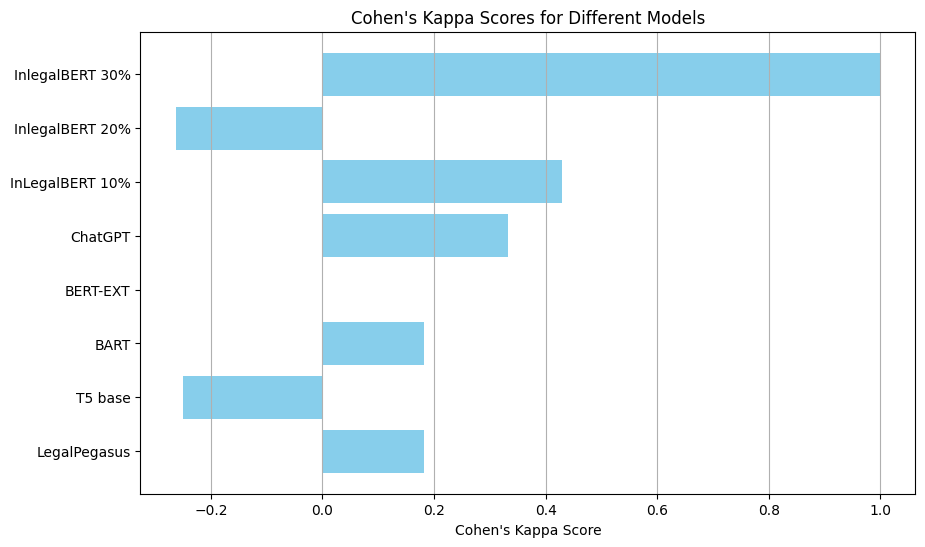

In [ ]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from matplotlib import pyplot as plt
#i removed top summary 2 ratings from excel

# Define the ratings for each evaluator and each model
evaluator_1_ratings = {
    'LegalPegasus': ['Readable', 'Readable', 'Partial-Readable', 'Partial-Readable', 'Readable', 'Readable'],
    'T5 base': [ 'Non-Readable', 'Partial-Readable', 'Readable', 'Non-Readable', 'Partial-Readable', 'Partial-Readable'],
    'BART': [ 'Non-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Readable', 'Readable'],
    'BERT-EXT': ['Non-Readable', 'Readable', 'Non-Readable', 'Non-Readable', 'Partial-Readable', 'Partial-Readable'],
    'ChatGPT': [ 'Readable', 'Readable', 'Partial-Readable', 'Readable', 'Readable', 'Readable'],
    'InLegalBERT 10%': [ 'Partial-Readable', 'Readable', 'Partial-Readable', 'Partial-Readable', 'Readable', 'Readable'],
    'InlegalBERT 20%': [ 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Non-Readable', 'Readable', 'Readable'],
    'InlegalBERT 30%': ['Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Non-Readable', 'Partial-Readable', 'Partial-Readable']
}

evaluator_2_ratings = {
    'LegalPegasus': [ 'Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable'],
    'T5 base': [ 'Non-Readable', 'Non-Readable', 'Partial-Readable', 'Partial-Readable', 'Readable', 'Readable'],
    'BART': ['Non-Readable', 'Non-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable'],
    'BERT-EXT': ['Non-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Readable'],
    'ChatGPT': ['Readable', 'Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Readable'],
    'InLegalBERT 10%': [ 'Non-Readable', 'Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Readable'],
    'InlegalBERT 20%': [ 'Partial-Readable', 'Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Partial-Readable'],
    'InlegalBERT 30%': ['Partial-Readable', 'Partial-Readable', 'Partial-Readable', 'Non-Readable', 'Partial-Readable', 'Partial-Readable']
}

# Function to calculate Cohen's Kappa for each model
def calculate_kappa(evaluator_1, evaluator_2):
    return cohen_kappa_score(evaluator_1, evaluator_2)

# Calculate Cohen's Kappa for each model
kappa_scores = {}
for model in evaluator_1_ratings:
    evaluator_1 = evaluator_1_ratings[model]
    evaluator_2 = evaluator_2_ratings[model]
    kappa_scores[model] = calculate_kappa(evaluator_1, evaluator_2)

kappa_scores


# Visualize the Kappa Scores
models = list(kappa_scores.keys())
scores = list(kappa_scores.values())

plt.figure(figsize=(10, 6))
plt.barh(models, scores, color='skyblue')
plt.xlabel("Cohen's Kappa Score")
plt.title("Cohen's Kappa Scores for Different Models")
plt.grid(True, axis='x')
plt.show()

In [ ]:
kappa_scores

{'LegalPegasus': 0.18181818181818188,
 'T5 base': -0.25,
 'BART': 0.18181818181818166,
 'BERT-EXT': 0.0,
 'ChatGPT': 0.33333333333333337,
 'InLegalBERT 10%': 0.4285714285714286,
 'InlegalBERT 20%': -0.26315789473684204,
 'InlegalBERT 30%': 1.0}

## 3 Evaluator Aggreement

## Krippendorff alpha coefficient

In [1]:
pip install krippendorff


In [48]:
import krippendorff

data = {
    "LegalPegasus": [
        ["Partial-Readable", "Readable", "Partial-Readable"],
        ["Non-Readable", "Partial-Readable", "Readable"],
   #     ["Partial-Readable", "Readable", "Partial-Readable"],
     0   ["Partial-Readable", "Readable", "Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
       # ["Partial-Readable", "Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
      #  ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    ],
    "T5 base": [
        ["Partial-Readable", "Partial-Readable", "Readable"],
        ["Partial-Readable", "Readable", "Readable"],
   #     ["Partial-Readable", "Partial-Readable", "Readable"],
        ["Partial-Readable", "Readable", "Readable"],
        ["Readable", "Partial-Readable", "Readable"],
    #    ["Partial-Readable", "Partial-Readable", "Readable"],
        ["Partial-Readable", "Readable", "Readable"],
        ["Readable", "Readable", "Readable"],
    #    ["Readable", "Partial-Readable", "Readable"],
    ],
    "BART": [
        ["Readable", "Readable", "Partial-Readable"],
        ["Readable", "Readable", "Readable"],
   #     ["Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Non-Readable"],
        ["Partial-Readable", "Readable", "Partial-Readable"],
  #      ["Partial-Readable", "Partial-Readable", "Readable"],
        ["Readable", "Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    #    ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    ],
    "BERT-EXT": [
        ["Partial-Readable", "Readable", "Readable"],
        ["Non-Readable", "Partial-Readable", "Partial-Readable"],
 #       ["Non-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Readable", "Partial-Readable"],
        ["Non-Readable", "Partial-Readable", "Partial-Readable"],
   #     ["Non-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
  #      ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    ],
    "ChatGPT": [
        ["Readable", "Readable", "Readable"],
        ["Readable", "Partial-Readable", "Readable"],
   #     ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Readable", "Partial-Readable", "Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
     #   ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Readable", "Partial-Readable", "Readable"],
        ["Readable", "Partial-Readable", "Partial-Readable"],
   #     ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    ],
    "InLegalBERT 10%": [
        ["Partial-Readable", "Non-Readable", "Non-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    #    ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    #    ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Readable", "Partial-Readable", "Partial-Readable"],
    #    ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    ],
    "InlegalBERT 20%": [
        ["Partial-Readable", "Partial-Readable", "Non-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    #    ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    #    ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Non-Readable"],
        ["Partial-Readable", "Partial-Readable", "Non-Readable"],
  #      ["Non-Readable", "Partial-Readable", "Non-Readable"],
    ],
    "InlegalBERT 30%": [
        ["Partial-Readable", "Partial-Readable", "Readable"],
        ["Partial-Readable", "Partial-Readable", "Readable"],
   #     ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Readable"],
     #   ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
        ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
     #   ["Partial-Readable", "Partial-Readable", "Partial-Readable"],
    ],
}

for model_name, ratings in data.items():
    # Specify the level of measurement and value domain
    alpha = krippendorff.alpha(
        reliability_data=ratings,
        level_of_measurement='ordinal',  # Specify 'ordinal' for ordered data
        value_domain=['Non-Readable', 'Partial-Readable', 'Readable']  # Define the order
    )
    print(f"{model_name}: {alpha:.4f}")

LegalPegasus: 0.1105
T5 base: 0.2444
BART: 0.1114
BERT-EXT: 0.1928
ChatGPT: 0.2350
InLegalBERT 10%: 0.0347
InlegalBERT 20%: 0.3200
InlegalBERT 30%: 0.3200


## Training T5 model

In [ ]:
import os
from transformers import T5Tokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths to judgment and summary folders
judgment_folder = '/content/drive/MyDrive/1 sample paheli/judgment'
summary_folder = '/content/drive/MyDrive/1 sample paheli/summary'

# Load data from files
data = []
judgment_files = os.listdir(judgment_folder)

for judgment_file in judgment_files:
    judgment_path = os.path.join(judgment_folder, judgment_file)
    summary_path = os.path.join(summary_folder, judgment_file)

    if os.path.exists(summary_path):  # Ensure the summary file exists
        with open(judgment_path, 'r', encoding='utf-8') as j_file:
            judgment_text = j_file.read()

        with open(summary_path, 'r', encoding='utf-8') as s_file:
            summary_text = s_file.read()

        data.append({"input_text": judgment_text, "target_text": summary_text})
        print(judgment_file)

# Convert to DataFrame for easy handling
df = pd.DataFrame(data)

# Split into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.1, random_state=42)


166.txt
165.txt
161.txt
162.txt
164.txt
163.txt
16.txt
159.txt
160.txt
157.txt
158.txt
153.txt
151.txt
152.txt
150.txt
155.txt
154.txt
131.txt
135.txt
132.txt
134.txt
156.txt
147.txt
140.txt
143.txt
145.txt
144.txt
146.txt
142.txt
149.txt
15.txt
148.txt
133.txt
136.txt
137.txt
138.txt
139.txt
14.txt
141.txt
130.txt
13.txt
124.txt
125.txt
128.txt
119.txt
120.txt
118.txt
129.txt
122.txt
126.txt
127.txt
114.txt
116.txt
113.txt
12.txt
117.txt
123.txt
121.txt
108.txt
105.txt
104.txt
107.txt
110.txt
111.txt
11.txt
109.txt
1012.txt
1013.txt
101.txt
1010.txt
1011.txt
115.txt
106.txt
112.txt
102.txt
103.txt
1009.txt
1007.txt
1004.txt
1001.txt
1002.txt
1003.txt
100.txt
10.txt
1.txt
1008.txt
1006.txt
1005.txt
1000.txt
167.txt
188.txt
187.txt
186.txt
184.txt
181.txt
180.txt
182.txt
183.txt
189.txt
185.txt
176.txt
175.txt
171.txt
17.txt
169.txt
173.txt
170.txt
18.txt
179.txt
177.txt
178.txt
168.txt
172.txt
174.txt
22.txt
218.txt
217.txt
216.txt
219.txt
215.txt
213.txt
212.txt
214.txt
209.txt
210.tx

In [ ]:
train_data

,input_text,target_text
716,Appeal No. 227 of 1958.\nAppeal by special lea...,One of the items in dispute referred to the In...
351,Appeal No. 224 of 1955.\n665 Appeal by special...,"The appellant was carrying on business, but wa..."
936,Appeal No. 83 of 1956.\nAppeal from the judgme...,The respondent sued the State of Bihar for a d...
256,Appeal No. 118 of 1953.\nAppeal from the Judgm...,It is now well settled that the general custom...
635,Appeal No. 410 of 1958.\nAppeal by special lea...,"The appellant, who was a candidate for electio..."
...,...,...
106,on No. 29 of 1953.\nPetition under article 32 ...,Section 112 of the Ajmer Tenancy and Land Reco...
270,Criminal Appeal No. 88 of 1954.\nAppeal by Spe...,A question of sentence is a matter of discreti...
860,Appeal No. 335 of 1956.\nAppeal by special lea...,The appellant was the administrator of the est...
435,Appeals Nos. 346 to 363 of 1956.\nAppeals unde...,These appeals by the State of Assam and some o...


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Initialize tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

# Define custom dataset class
class SummarizationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len_input=512, max_len_target=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len_input = max_len_input
        self.max_len_target = max_len_target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_text = "summarize: " + self.data.iloc[index]['input_text']
        target_text = self.data.iloc[index]['target_text']

        input_tokens = self.tokenizer.encode_plus(
            input_text,
            max_length=self.max_len_input,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        target_tokens = self.tokenizer.encode_plus(
            target_text,
            max_length=self.max_len_target,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': input_tokens['input_ids'].squeeze(),
            'attention_mask': input_tokens['attention_mask'].squeeze(),
            'labels': target_tokens['input_ids'].squeeze()
        }

# Create datasets and dataloaders
train_dataset = SummarizationDataset(train_data, tokenizer)
val_dataset = SummarizationDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)


# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Use PyTorch AdamW
scaler = GradScaler()

# Define the number of training epochs
epochs = 5  # You can adjust this value as needed

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():  # Mixed precision
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} completed. Training loss: {epoch_loss / len(train_loader)}")

    # Evaluate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    print(f"Validation loss after epoch {epoch + 1}: {val_loss / len(val_loader)}")

Epoch 1 completed. Training loss: 3.8605630840875405
Validation loss after epoch 1: 2.730729341506958
Epoch 2 completed. Training loss: nan
Validation loss after epoch 2: 2.6379167483403134
Epoch 3 completed. Training loss: 2.9247801113972622
Validation loss after epoch 3: 2.590321870950552
Epoch 4 completed. Training loss: nan
Validation loss after epoch 4: 2.5561812290778527
Epoch 5 completed. Training loss: nan
Validation loss after epoch 5: 2.529953883244441


In [ ]:
model.save_pretrained('/content/drive/MyDrive/fine_tuned_t5')
tokenizer.save_pretrained('/content/drive/MyDrive/fine_tuned_t5')


('/content/drive/MyDrive/fine_tuned_t5/tokenizer_config.json',
 '/content/drive/MyDrive/fine_tuned_t5/special_tokens_map.json',
 '/content/drive/MyDrive/fine_tuned_t5/spiece.model',
 '/content/drive/MyDrive/fine_tuned_t5/added_tokens.json')

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained('/content/drive/MyDrive/fine_tuned_t5')
model = T5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/fine_tuned_t5')

def generate_summary(input_text):
    input_ids = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=128, min_length=32, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Test with a new judgment text
new_judgment_text = """ON: Criminal Appeal No. 126 of 1955.
Appeal by special leave from the judgment and order dated the 9th August 1955 of the Bombay High Court in Criminal Application No. 726 of 1955.
M. R. Parpia, J. B. Dadachanji and section N. Andley, for the appellant.
M. C. Setalvad, Attorney General for India, B. Sen and R. H. Dhebar, for the respondent.
April 24.
The Judgment of the Court was delivered by JAGANNADHADAS J.
This is an appeal by special leave against the judgment of the High Court of Bombay dismissing an application made to it under article 226 of the Constitution.
These proceedings relate to the validity of an order of detention passed by the Government of Bombay on the 8th June, 1955, against the appellant before us, who is an Advocate of the High Court of Bombay having a standing of about thirty years.
He was in the Indian Air Force as an emergency Commissioned Officer between 1943 to 1948 and thereafter on extension for another four years until he attained the age of 55.
It appears that he was also interested in journalism and in public affairs.
On his own showing, he was concerned over the political future of Goa and "was opposed to any attempts at intimidation of Indian residents of Goan origin by other political groups and has freely expressed these views in his journalistic articles".
He was arrested on the 9th June, 1955, and is in detention since then under the impugned order, which runs as follows: 384 "No. P. D. A. 1555A. Political and Services Department, Secretariat, Bombay, 8th June, 1955.
O R D E R.
Whereas the Government of Bombay is satisfied with respect to the person known as Shri Lawrence Joachim Joseph DeSouza of Bombay, that with a view to preventing him from acting in any manner prejudicial to the relations of India with the Portuguese Government and to the Security of India, it is necessary to make the following Order: Now, therefore, in exercise of the powers conferred by sub clause (1) of clause (a) of sub section (1) of section 3 of the (Act IV of 1950) the Government of Bombay is pleased to direct that Shri Lawrence Joachim Joseph DeSouza of Bombay, be detained.
By Order and in the name of the Governor of Bombay.
Under Secretary to the Government of Bombay.
Political and Services Department".
In pursuance of section 7 of the (Act IV of 1950) (hereinafter referred to as the Act) the grounds of detention, also dated the 8th June, 1955, was served on him along with the order of detention.
The validity of the order is challenged on the following contentions.
1.The order of detention was mala fide.
It was passed for the ulterior purpose of preventing his freedom of speech and freedom of professional activity in the sphere of Goan affairs by reason of his known views in this behalf.
2.The detaining authority,in exercising its power, failed to apply its mind to the existence or otherwise of the legitimate objects of detention.
The grounds of detention are vague.
385 4.The claim of State that no particulars of the grounds could be furnished in public interest is unsustainable and in any case mala fide.
The last two have been urged before us not only as independent points but as reinforcing the first two.
The challenge to the validity of the order based on the attack of mala fides and non application of the, mind of the detaining authority, have been urged before us with great insistence.
We have been taken elaborately into what is claimed to be the relevant previous background of events.
This part of the argument raises, what ultimately are questions of fact which have been fully considered by the High Court.
It is, therefore, enough to state, in its broad outlines, the background, which is alleged as follows: (1)(a) There was a sudden search by the police on the 24th August, 1954, at the appellant 's place for alleged possession of illicit liquor.which, in fact, was not found.
But under the guise thereof the police seized and carried away a mass of documents, papers and printed material of the appellant as also a typewriter belonging to him.
(b)On the same day, a search was carried out by the police also at his residence at Mahim but nothing was found.
(c)Immediately following the searches, the appellant was taken into illegal police custody and interrogated, and physically assaulted, and threatened.
The above high handed action of the police, by way of search and seizure, was the subject matter of challenge by the appellant by means of a writ application in the High Court in which the police officers concerned filed affidavits virtually admitting the appellant 's allegations relating to seizure of papers, etc.
The State itself could not support the said highhandedness.
As a result, the High Court directed on the 3rd November, 1954, the return forthwith of all the papers and articles seized.
Notwithstanding that order, the materials so illegally seized were returned only on or about the 21st January, 1955.
(2) When one Joaquim Carlos, a Portuguese soldier 386 attached to Goan forces, was arrested on a charge of entering Indian territory without the requisite authority, the appellant rendered professional assistance to him and obtained an order of release on bail from the Chief Presidency Magistrate, Bombay, which was foiled by the police by removing him away to Sawantwadi before the requisite sureties could be obtained at Bombay.
The trial was hurried through and the said Carlos was convicted.
But on appeal, filed by the appellant, before the Sessions Judge, the conviction was set aside and retrial ordered.
These events happened between February to April, 1955.
(3)Between April, 1955 to June, 1955, there occurred certain incidents which were inspired and instigated by the members of the Goan Action Committee who were agitating against Portuguese hold over Goa.
There was a raid on certain pro Portuguese presses by some private persons, in the course of which heavy damage was caused.
There was also an assault on himself (appellant) by a gang of persons of whom some were employees of the Goan Action Committee.
In respect of these two incidents private complaints had been filed by or on behalf of the affected persons.
The attitude and behaviour of the police in respect of these complaints were clearly indicative of their being in league with the Goan Action Committee.
The appellant 's counsel strongly urged that the bona fides of the detaining authority is to be judged with reference to the above background of events and that viewed in that light the vagueness of the grounds and the belated claim of privilege under article 22(6) of the Constitution strengthen his contention.
He also relied on what are urged as being certain discrepancies in the affidavits of the Under Secretary and the Chief Secretary filed in the High Court in these proceedings.
It is strongly urged that the order of detention was made without any real application of mind by the detaining authority, that the authority acted merely at the instance of the police who were in league with the Goan Action Committee, and that the police procured the detention 387 order for the purpose of suppressing the freedom of the appellant, to ventilate his point of view on the Goan politics and to take up professionally the cause of persons in the position of Carlos.
We have been taken through all the material relating to the above allegations and have given our consideration to the same.
It is enough to say that we are unable to see any reason for disagreeing with the conclusion of the High Court to the effect that the material is not enough to make out that the detaining authority was acting otherwise than bona fide.
We also agree with the view of the High Court that, what has got to be made out is not the want of bona fides on the part of the police, but want of bona fides, as well as the non application of mind, on the part of the detaining authority, viz. the Government, which for this purpose must be taken to be different from the police.
It is also clear that the allegation of non application of mind by the detaining authority is without any basis, in view of the affidavit of the Chief Secretary.
The further points that remain for consideration are those which relate to the complaint of vagueness of the grounds furnished and the alleged unsustainable claim for non disclosure under article 22(6) of the Constitution on behalf of the detaining authority, to get over the alleged vagueness.
To appreciate the points thus raised, it is necessary to have an idea of the grounds of detention as furnished.
They are to be found from the relevant communication to the detenue which is as follows: "In pursuance of section 7 of the (Act IV of 1950) you are hereby informed that the grounds on which a detention order has been made against you, by the Government of Bombay under sub clause (1) of clause (a) of subsection (1) of section 3 of the said Act are that: With the financial help given by the Portuguese authorities you are carrying on espionage on behalf of the Portuguese Government with the help of underground workers.
You are also collecting intelligence about the security arrangements on the border area and you make such intelligence available to the Portu 388 guese authorities.
These activities which are being carried on by you with the object of causing further deterioration in the relations between the Portuguese Government and the Indian Government over the question of Goan National Movement, are prejudicial to the security of India and to the relations of India with Portugal.
2.If you wish to make a representation against the order under which you are detained, you should address it to the Government of Bombay and forward it through the Superintendent, Arthur Road Prison, Bombay.
3.You are also informed that you have a right to claim a personal hearing before the Advisory Board and that you should communicate to Government of Bombay as soon as possible your intention of exercising or not exercising that right".
The objection by the appellant relating to this is contained in paragraph 15(g) of his application before the High Court.
It is as follows: "The grounds are not specific and no particulars of the activities alleged to have been carried on by the petitioner are given, viz. the particulars such as the length of period for which the petitioner is alleged to have carried on the so called espionage activities or the details of financial aid alleged to have been received by the petitioner from the Portuguese authorities or the names of any of the so called underground workers alleged to be aiding the petitioner or any details of intelligence alleged to have been collected by the petitioner or made available by him to the Portuguese Government".
The answer thereto of the Under Secretary to the Government of Bombay is in paragraph 12 of his affidavit dated the 25th July, 1955, and is as follows: "With reference to paragraph 15, clause (g), I submit that it is not necessary to mention particulars of the espionage activities carried on by the petitioner or the details of the financial aid received by him or the names of the persons aiding the said petitioner.
It is not in public interest to disclose these details; nor is it necessary to mention these matters to afford 389 the petitioner reasonable opportunity to make a representation" Now the question as to whether the grounds furnished are vague or not, is ultimately a question that has to be determined on a consideration of the circumstances of each case, as was pointed out by this court in the State of Bombay vs Atma Ram Sridhar Vaidya(1) in the following passage: "The contention that the grounds are vague requires some clarification. . . .
If the ground which is supplied is incapable of being understood or defined with sufficient certainty it can be called vague.
It is not possible to state affirmatively more on the question of what is vague.
It must vary according to the circumstances of each case. . . .
If on reading the ground furnished it is capable of being intelligently understood and is sufficiently definite to furnish materials to enable the detained person to make a representation against the order of detention it cannot be called vague".
In the present case, the detenue has been intimated why, in the opinion of the Government the activities of the appellant are considered prejudicial to the security of India and to the relations of India with Portugal.
They are the following: 1.With the financial help given by the Portuguese authorities, he is carrying on espionage on behalf of the Portuguese Government with the help of underground workers.
2.He is collecting intelligence about the security arrangements on the border area and making such intelligence available to the Portuguese authorities.
3.He is carrying on these activities with the object of causing further deterioration in the relations between the Portuguese Government and the Indian Government over the question of the Goan National Movement.
It is true that these allegations are not as precise and specific as might have been desired.
But having regard to the nature of the alleged activities of the appellant, it is not unlikely that no more could be gathered or furnished.
In this context it is relevant (1) ; ,184.
51 390 to notice that the appellant himself does not appear to have felt that the grounds furnished were so vague as to hamper him in his right to make a representation under article 22(5) and section 7 of the Act.
It does not appear that he applied to the Government to be supplied with particulars of the grounds furnished to him.
Such a right to call for particulars has been recognised in the case in the State of Bombay vs Atma Ram Sridhar Vaidya(1) as flowing from his constitutional right to be afforded a reasonable opportunity to make a representation to the Board.
In that case it has been stated that "if the grounds are not sufficient to enable the detenue to make a representation, the detenue. . if he likes, may ask for particulars which would enable him to make the representation".
The fact that be bad made no such application for particulars is, therefore, a circumstance which may well be taken into consideration, in deciding whether the grounds can be considered to be vague.
In the circumstances and having regard to thefact that what is alleged is espionage activity ata time when relations between the two Governments on the affairs of Goa were somewhat delicate, we are inclined to think, with the High Court, that the grounds cannot be considered to be vague.
Assuming however that the grounds furnished in this case are open to the challenge of vagueness, the further question which arises is whether the validity of the order of detention can be sustained by reason of the claim, in public interest, of non disclosure of facts made by the Under Secretary to the Government of Bombay by means of his affidavit filed in the High Court.
Now it has been held in Atma Ram Sridhar Vaidya 's case(1) by the majority of the Court, that the constitutional right of a detenue under article 22(5) comprises two distinct components.
1.The right to be furnished grounds of detention as soon as may be; and 2.The right to be afforded the earliest opportunity of making a representation against his detention (1) ; ,184. 391 which implies, the right to be furnished adequate particulars of the grounds of detention, to enable a proper representation being made.
These rights involve corresponding obligations on the part of the detaining authority.
It follows that the authority is under a constitutional obligation to furnish reasonably definite grounds, as well as adequate particulars then and there, or shortly thereafter.
But the right of the detenue to be furnished particulars, is subject to the limitation under article 22(6) whereby disclosure of facts considered to be against public interest cannot be required.
It is however to be observed that under article 22(6) the facts which cannot be required to be disclosed are those "which such authority considers to be against public interest to disclose".
Hence it follows that both the obligation to furnish particulars and the duty to consider whether the disclosure of any facts involved therein is against public interest, are vested in the detaining authority, not in any other.
It was accordingly attempted to be argued in the High Court that the claim of non disclosure made in the affidavit of the Under Secretary indicated a decision for nondisclosure, by the Under Secretary himself and that too at the time of filing the affidavit.
On this assumption it was contended that the claim for non disclosure was invalid.
The High Court, however, on a consideration of the material, felt satisfied that what was stated in the affidavit related to the decision of the detaining authority itself, taken at the time.
The learned Judges expressed their conclusion as follows: "There is nothing in the affidavit of Mr. Bambawala to suggest that it is now that the detaining authority is claiming privilege or applying its mind to the question of privilege. . . . .
The meaning is clear that at no time it was in public interest to disclose the details referred to in the particular paragraph of the affidavit and there is nothing to suggest that this question was not considered by the detaining authority at the time when the grounds were furnished".
No argument has been addressed to us how this con 392 elusion is incorrect.
But what has been urged before us is that the decision not to disclose the facts as well as the ambit of the non disclosure must be clearly communicated to the detenue at the time when the grounds are furnished.
It is urged that if the detenue is furnished information, at least to that extent, it will enable him to present to the Advisory Board his difficulties in making a proper representation and to convey to it a request for obtaining the requisite particulars from the State under section 10 of the Act for their own information and consideration.
We are unable to imply any such obligation under article 22(5) and (6).
The necessity for such a communication would arise only if the detenue, feeling the grounds to be vague, asks for particulars.
An obligation to communicate the decision not to disclose facts considered prejudicial to public interest may well be implied in such a situation.
But in the absence of any such request by the detenue, the non communication of the decision cannot be held to have hampered his constitutional right of representation and an obligation to communicate cannot be implied in these circumstances.
In the present case there is no merit in this contention.
If the appellant bad exercised his right to ask for particulars, at the time, from the detaining authority, there can be no doubt that he would have been furnished then the very information which has been supplied in paragraph 12 of the Under Secretary 's affidavit in answer to para 15(g) of the appellant 's petition, both of which have been already set out above.
A faint suggestion has been made in the course of the arguments before us that the decision not to disclose particulars is mala fide and that such mala fides has to be imputed in a case where no particulars are at all furnished.
It is suggested that the power not to disclose facts considered against public interest cannot be so exercised as to nullify the constitutional right of the detenue for being afforded a proper opportunity of representation.
Such a contention as to the mala fide exercise of the power is untenable in the present case having regard to the nature of the 393 grounds on which the detention is based and the nature of activities imputed therein to the appellant.
It is unnecessary, therefore, to deal in this case with a theoretical contention as to whether or not article 22(6) of the Constitution overrides the constitutional right to be furnished particulars under article 22(5) to the extent of denying all particulars and leaving the grounds absolutely vague.
All the contentions raised before us fail and this appeal is dismissed. """
generated_summary = generate_summary(new_judgment_text)
print("Generated Summary:", generated_summary)


Generated Summary: This is an appeal by special leave against the judgment of the High Court of Bombay dismissing an application made to it under article 226 of the Constitution. The appellant is an Advocate of the High Court of Bombay having a standing of about thirty years. He was in the Indian Air Force as an emergency Commissioned Officer between 1943 to 1948 and thereafter on extension for another four years until he attained the age of 55. He was arrested on the 9th June, 1955, and is in detention since then under the impugned order. Whereas the Government of Bombay
